#### Importing and setting up Wikipedia, ArXiv & Tavily Search Tools

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from pprint import pprint

In [8]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [9]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen-qwq-32b")

In [36]:
arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=350)
arxiv = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)
arxiv.name

'arxiv'

In [37]:
wiki_api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=350)
wiki = WikipediaQueryRun(api_wrapper=wiki_api_wrapper)
wiki.name

'wikipedia'

In [12]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of"

In [16]:
wiki.invoke("Generative AI")

'Page: Generative artificial intelligence\nSummary: Generative artificial intelligence (Generative AI, GenAI, or GAI) is a subfield of artificial intell'

In [17]:
tavily = TavilySearchResults()

C:\Users\Soham\AppData\Local\Temp\ipykernel_1424\2290291758.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [18]:
tavily.invoke("Recent Cricket News of June 2025")

[{'title': 'Cricket | The Guardian',
  'url': 'https://www.theguardian.com/sport/cricket',
  'content': "![](https://sb.scorecardresearch.com/p?c1=2&c2=6035250&cv=2.0&cj=1&cs_ucfr=0&comscorekw=sport)\n\n## Cricket\n\n## 18 June 2025\n\n![David Lawrence and Shaun Udal pose for a photo during the T20 Vitality Blast semi-final match  last September.](https://i.guim.co.uk/img/media/6ee2cd77dc9c4cf3e8712def8a9093e791d66eed/215_0_2485_1988/master/2485.jpg?width=465&dpr=1&s=none&crop=5%3A3)\n\n### The Spin newsletter David ‘Syd’ Lawrence’s brave race against time to tell his remarkable story\n\n## 17 June 2025 [...] ![Andy Bull](https://i.guim.co.uk/img/uploads/2025/06/10/Andy_Bull.png?width=75&dpr=1&s=none&crop=none)\n\n### Tendulkar v Anderson: two master craftsmen who gave more than most to Test cricket\n\n![Michael Levitt plays a shot for Netherlands](https://i.guim.co.uk/img/media/3781f6adbf76a51b385ab6590d0ab13bdd88e636/815_119_2417_1933/master/2417.jpg?width=465&dpr=1&s=none&crop=5%3A3

In [38]:
tools = [arxiv, wiki, tavily]

In [39]:
llm_with_tools = llm.bind_tools(tools)

In [22]:
from langchain_core.messages import HumanMessage

response = llm_with_tools.invoke([HumanMessage(content=f"Generative Adversial Networks")])

In [23]:
response.tool_calls

[{'name': 'wikipedia',
  'args': {'query': 'Generative adversarial network'},
  'id': 'p5we30c09',
  'type': 'tool_call'},
 {'name': 'arxiv',
  'args': {'query': 'Generative Adversarial Networks'},
  'id': 'j4fbc8a6h',
  'type': 'tool_call'},
 {'name': 'tavily_search_results_json',
  'args': {'query': 'Generative Adversarial Networks applications and recent developments'},
  'id': 'm1294se10',
  'type': 'tool_call'}]

#### Creating a LangGraph chatbot integrated with these tools

In [40]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

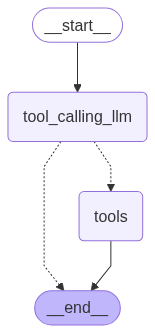

In [41]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (avq984238)
 Call ID: avq984238
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
perf


In [43]:
messages=graph.invoke({"messages":HumanMessage(content="XGBoost")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

XGBoost
================================== Ai Message ==================================
Tool Calls:
  wikipedia (vba6qfp5h)
 Call ID: vba6qfp5h
  Args:
    query: XGBoost
  tavily_search_results_json (wb84rasqq)
 Call ID: wb84rasqq
  Args:
    query: XGBoost latest developments and applications
================================= Tool Message =================================
Name: wikipedia

Page: XGBoost
Summary: XGBoost (eXtreme Gradient Boosting) is an open-source software library which provides a regularizing gradient boosting framework for C++, Java, Python, R, Julia, Perl, and Scala. It works on Linux, Microsoft Windows, and macOS. From the project description, it aims to provide a "Scalable, Portable and Distributed Gradient Boo
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "3.0.0 (2025 Feb 27) — xgboost 3.1.0-dev docum

In [44]:
messages=graph.invoke({"messages":HumanMessage(content="Name something which is known as the powerhouse of the cell.")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Name something which is known as the powerhouse of the cell.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (z6fsxb8hs)
 Call ID: z6fsxb8hs
  Args:
    query: powerhouse of the cell
  wikipedia (ph9rqr1a3)
 Call ID: ph9rqr1a3
  Args:
    query: powerhouse of the cell
  wikipedia (mnm6mr85f)
 Call ID: mnm6mr85f
  Args:
    query: powerhouse of the cell
================================= Tool Message =================================
Name: wikipedia

Page: Mitochondrion
Summary: A mitochondrion (pl. mitochondria) is an organelle found in the cells of most eukaryotes, such as animals, plants and fungi. Mitochondria have a double membrane structure and use aerobic respiration to generate adenosine triphosphate (ATP), which is used throughout the cell as a source of chemical energy. They were disc
================================= Tool Message ==========

In [45]:
messages=graph.invoke({"messages":HumanMessage(content="Which is the latest discovered prime number?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Which is the latest discovered prime number?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (wmf7zrx50)
 Call ID: wmf7zrx50
  Args:
    query: Largest known prime number
================================= Tool Message =================================
Name: wikipedia

Page: Largest known prime number
Summary: The largest known prime number is 2136,279,841 − 1, a number which has 41,024,320 digits when written in the decimal system. It was found on October 12, 2024, on a cloud-based virtual machine volunteered by Luke Durant, a 36-year-old researcher from San Jose, California, to the Great Internet Mersenne Prime


In [46]:
messages=graph.invoke({"messages":HumanMessage(content="Calculate the square root of 1024.")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Calculate the square root of 1024.
================================== Ai Message ==================================

The square root of 1024 is **32**, because \( 32 \times 32 = 1024 \).

No external tools were needed here, as this is a straightforward mathematical calculation.


In [47]:
messages=graph.invoke({"messages":HumanMessage(content="Cuurent weather update in Pune, India.")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Cuurent weather update in Pune, India.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (6y422v16w)
 Call ID: 6y422v16w
  Args:
    query: current weather Pune India
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Pune weather in June 2025 - Weather25.com", "url": "https://www.weather25.com/asia/india/maharashtra/pune?page=month&month=June", "content": "/23°](https://www.weather25.com/asia/india/maharashtra/pune?page=today \"Weather in 18 june 2025\") | [19 Moderate rain 23° /22°](https://www.weather25.com/asia/india/maharashtra/pune?page=tomorrow \"Weather in 19 june 2025\") | [20 Patchy rain possible 25° /22°](https://www.weather25.com/asia/india/maharashtra/pune?page=day#date=2025-06-20 \"Weather in 20 june 2025\") | [21 Patchy rain possible 28° /23°](h